## PyTorch Workflow
  * Let's explore an example PyTorch end-to-end workflow

In [37]:
what_were_covering = {1: 'data - (prepare and load data)', 
                      2: 'build a model',
                      3: 'fitting the model to data - (training phase)',
                      4: 'making predictions and evaluating a model - (testing/inference)',
                      5: 'saving and loading a model',
                      6: 'putting it all together'}

what_were_covering

{1: 'data - (prepare and load data)',
 2: 'build a model',
 3: 'fitting the model to data - (training phase)',
 4: 'making predictions and evaluating a model - (testing/inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [38]:
import torch
import numpy as np
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
from matplotlib import pyplot as plt

## 1. Data - Preparing & Loading Data

In [39]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create a dataset with linear regrassion formula
start = 0
end = 1
step = 0.02
X = torch.arange(start=start, end=end, step=step).unsqueeze(dim=1) # X -> matrix/tensor
y = weight * X + bias # vector

## Splitting data into train & test sets
 * Traning set -> model learns patterns from here
 * Validation set -> tune model patterns
 * Testing set -> see if the model is ready for the wild

In [40]:
 # Let's create a training and testing set with our data
 # Create a train/test split

 split = int(0.8 * len(X))
 X_train, y_train = X[:split], y[:split]
 X_test, y_test = X[split:], y[split:]

 len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

## Visualize the data

In [41]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c='b', label='Train Data')

  # Plot testing data in green
  plt.scatter(test_data, test_labels, c='g', label='Test Data')

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c='r', label='Predictions')
  
  plt.legend(prop={'size': 14})

def visualize_loss(epoch_count_list, 
                   train_loss_list, 
                   test_loss_list):
  plt.figure(figsize=(10, 7))

  # Plot training loss
  plt.plot(epoch_count_list, train_loss_list, label='Train Loss')
  plt.plot(epoch_count_list, test_loss_list, label='Test Loss')
  plt.title('Train & Test Loss Curves')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(prop={'size': 14})

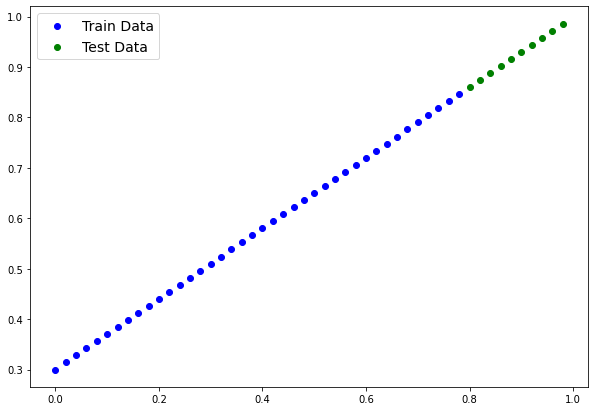

In [42]:
plot_predictions()

## 2. Build First PyTorch Model

In [43]:
# Create linear regrassion model class
from torch import nn

class LinearRegrassionModel(nn.Module):
  def __init__(self):
    super().__init__()
    
    # Initilize the model parameters
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    
    self.bias = nn.Parameter(torch.randn(1, 
                                         requires_grad=True,
                                         dtype=torch.float))
    
  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

## PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward() this method defines what happens in the forward computation


## Checking the contents of our PyTorch model

In [44]:
# Create a random seed
torch.manual_seed(42)

# Create a instance of the model
model = LinearRegrassionModel()

# Check out the parameters
print(f'model.parameter(): {list(model.parameters())}')
print(f'model.state_dict(): {model.state_dict()}')

model.parameter(): [Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]
model.state_dict(): OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])


## Making Prediction using `torch.inference_mode()`

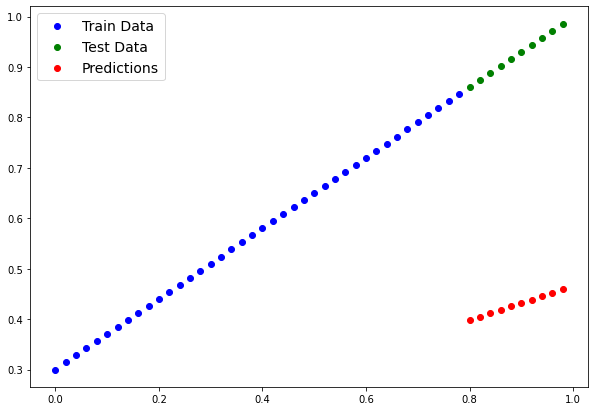

In [45]:
with torch.inference_mode():
  y_predictions = model(X_test)

plot_predictions(predictions=y_predictions)

## 3. Train Model

Things we need to train:
* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias in our case)

In [46]:
# Setup loss function and optimizer 

loss_function = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.01) # stochastic gradient descent

# Building a training loop (and testing loop) in PyTorch

A couple of things we need in a training loop: 
0. Loop through the data and do...
1. Forward pass (this involves data moving through our model's forward() functions) to make predictions on data - also called **forward propagation**
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation** - https://www.youtube.com/watch?v=tIeHLnjs5U8)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent** - https://youtu.be/IHZwWFHWa-w)


In [47]:
torch.manual_seed(42)
epochs = 150

epoch_count_list = []
train_loss_list = []
test_loss_list = []

# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward propagation
  train_predictions = model(X_train)

  # 2. Calculate the train loss
  train_loss = loss_function(train_predictions, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model (calculate gradients of each parameter)
  train_loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step()

  # Testing
  model.eval()
  with torch.inference_mode():
    # 1. Do the forward pass
    test_predictions = model(X_test)

    # 2. Calculate the test loss
    test_loss = loss_function(test_predictions, y_test)

  # Print each epoch
  print(f'Epoch: {epoch} | Training Loss: {train_loss} | Testing Loss: {test_loss}')
  print(model.state_dict())

  epoch_count_list.append(epoch)
  train_loss_list.append(train_loss)
  test_loss_list.append(test_loss)

Epoch: 0 | Training Loss: 0.31288138031959534 | Testing Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 1 | Training Loss: 0.3013603389263153 | Testing Loss: 0.4675942063331604
OrderedDict([('weights', tensor([0.3445])), ('bias', tensor([0.1488]))])
Epoch: 2 | Training Loss: 0.28983935713768005 | Testing Loss: 0.4541231691837311
OrderedDict([('weights', tensor([0.3484])), ('bias', tensor([0.1588]))])
Epoch: 3 | Training Loss: 0.2783183455467224 | Testing Loss: 0.44065219163894653
OrderedDict([('weights', tensor([0.3523])), ('bias', tensor([0.1688]))])
Epoch: 4 | Training Loss: 0.26679736375808716 | Testing Loss: 0.4271811842918396
OrderedDict([('weights', tensor([0.3562])), ('bias', tensor([0.1788]))])
Epoch: 5 | Training Loss: 0.2552763521671295 | Testing Loss: 0.41371020674705505
OrderedDict([('weights', tensor([0.3601])), ('bias', tensor([0.1888]))])
Epoch: 6 | Training Loss: 0.24375534057617188 | Testing Loss: 0.400239169597

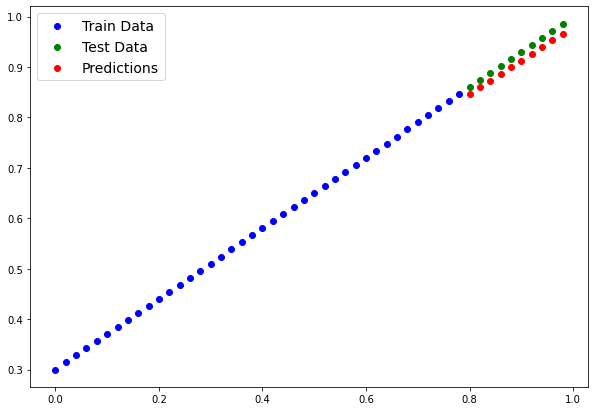

In [48]:
plot_predictions(predictions=test_predictions)

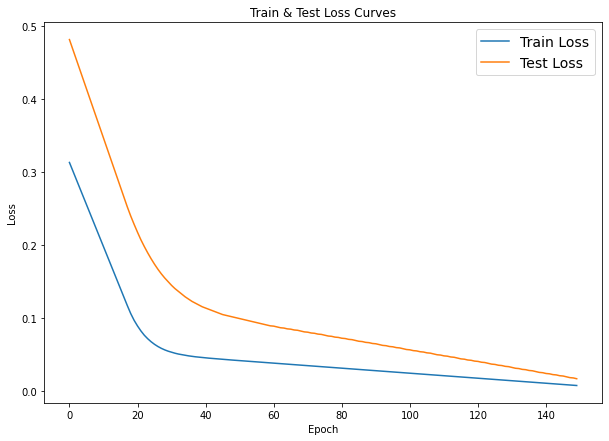

In [49]:
visualize_loss(np.array(torch.tensor(epoch_count_list).numpy()), np.array(torch.tensor(train_loss_list).numpy()), np.array(torch.tensor(test_loss_list).numpy()))

## Saving a Model in PyTorch

In [50]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = 'pytorch_workflow.pth'
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

# 3. Save the model state dict
torch.save(model.state_dict(), MODEL_SAVE_PATH)

## Loading a PyTorch model

In [51]:
# 1. To load in a saved state_dict, we have to instantiate a new instance of our model class
loaded_model = LinearRegrassionModel()

# 2. Load the saved state_dict of model
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [52]:
loaded_model.state_dict()

OrderedDict([('weights', tensor([0.6638])), ('bias', tensor([0.3153]))])

In [53]:
# Make some predictions with new loaded model

loaded_model.eval()
with torch.inference_mode():
  loaded_model_predictions = loaded_model(X_test)

loaded_model_predictions

tensor([[0.8464],
        [0.8596],
        [0.8729],
        [0.8862],
        [0.8995],
        [0.9127],
        [0.9260],
        [0.9393],
        [0.9526],
        [0.9659]])

In [54]:
loaded_model_predictions == test_predictions

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])